In [1]:
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

import pandas as pd
import os
import numpy as np

# file_dir = os.getcwd()
# raw_data_dir = os.path.join(file_dir, '/raw_data')
file_list = []

for root, dirs, files in os.walk('./raw_data'):
    for file in files:
        if os.path.splitext(file)[1] == '.csv':
        # 排除掉readme.md等非csv文件
            file_list.append(file)

# print(file_list)  

df = pd.DataFrame()

for index, csv in enumerate(file_list):
    
    df_temp = pd.read_csv('./raw_data/'+csv)
    if int(csv[-5]) == 0:
        file_list[index] = csv[:-5] + '1' +csv[-4:]
        print('changed csv: ', csv)
    target_column = pd.DataFrame(np.array([int(file_list[index][-5])]*df_temp.shape[0]))
    # 构造target列，注意要使用二维的array [[1],[1]]这样是列 [[1,1]]这样是行
    df_temp = pd.concat([df_temp, target_column], axis=1, ignore_index=True)
    # 连接样本和target列
    df = pd.concat([df, df_temp], ignore_index=True)
    # 连接所有样本
    
print(file_list)

df

target_column = df.iloc[:, -1]
df = df.iloc[:, :-1]

# 让脸部温度单独保存，环境温度设计为统一值
ta = df.min(axis=1)

df_face = pd.DataFrame()
# df_face 脸部温度+其他区域温度置换为环境温度
df_onlyface = pd.DataFrame()
# df_onlyface 只有脸部温度点

for i, minTa in zip(df.values, ta):
    face = []
    onlyface = []
    for j in i:
        try:
        # 因为检查到有一些数字不是float是str，像21.42346.1，不知是什么原因导致的，
            if j - minTa > 7:
                face.append(j)
#                 onlyface.append(j)
            else:
                face.append(minTa)
        except:
            j = float(j[:6])
            if j - minTa > 7:
                face.append(j)
#                 onlyface.append(j)
            else:
                face.append(minTa)
    face_todf = pd.DataFrame(face).T
#     onlyface_todf = pd.DataFrame(onlyface).T
    df_face = pd.concat([df_face, face_todf], axis = 0, ignore_index=True)
#     df_onlyface = pd.concat([df_onlyface, onlyface_todf], axis = 0, ignore_index=True)

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=40, contamination=0.05)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(df_face)
# n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

min_index = np.argpartition(X_scores, int(df_face.shape[0]*0.05))[:int(df_face.shape[0]*0.05)]

# 去除掉5%的异常样本
df = df.drop(min_index)

df

for i, minTa in zip(df.values, ta):
#     face = []
    onlyface = []
    for j in i:
        try:
        # 因为检查到有一些数字不是float是str，像21.42346.1，不知是什么原因导致的，
            if j - minTa > 7:
#                 face.append(j)
                onlyface.append(j)
#             else:
#                 face.append(minTa)
        except:
            j = float(j[:6])
            if j - minTa > 7:
#                 face.append(j)
                onlyface.append(j)
#             else:
#                 face.append(minTa)
#     face_todf = pd.DataFrame(face).T
    onlyface_todf = pd.DataFrame(onlyface).T
#     df_face = pd.concat([df_face, face_todf], axis = 0, ignore_index=True)
    df_onlyface = pd.concat([df_onlyface, onlyface_todf], axis = 0, ignore_index=True)

skewness = pd.DataFrame(df_onlyface.skew(axis=1))
maxTemp = pd.DataFrame(df_onlyface.max(axis=1))
minTemp = pd.DataFrame(df_onlyface.min(axis=1))
meanTemp = pd.DataFrame(df_onlyface.mean(axis=1))

# 指定划分bin的点
bins = [28.3, 28.6, 28.9, 29.2, 29.5,
 29.8, 30.1, 30.4, 30.7, 31.0,  31.3,
 31.6, 31.9, 32.2, 32.5,  32.8, 33.1,
 33.4, 33.7, 34.0,  34.3, 34.6, 34.9,
 35.2, 35.5, 35.8, 36.1, 36.4, 36.7]

highest_bin_list = []
for i in df_onlyface.values:
    i = [j for j in i if not np.isnan(j)]
    N, _ = np.histogram(np.clip(i,28.3,36.7), bins=bins)
    highest_bin = (bins[N.argmax()]+bins[N.argmax()+1])/2
    # 返回各区域频数N
    highest_bin_list.append(highest_bin)

modeTemp = pd.DataFrame(highest_bin_list, index=df_onlyface.index)

features = pd.concat([skewness, maxTemp, minTemp, meanTemp, modeTemp, ta], axis=1, join="inner")
features.columns = ['skewness', 'maxTemp', 'minTemp', 'meanTemp', 'modeTemp', 'ta']

features['max_minus_min'] = features['maxTemp'] - features['minTemp']
features['mode_minus_ta'] = features['modeTemp'] - features['ta']
# features['mean_minus_ta'] = features['meanTemp'] - features['ta']
# features['max_minus_ta'] = features['maxTemp'] - features['ta']
features['min_minus_ta'] = features['minTemp'] - features['ta']
# features['mode_minus_min'] = features['modeTemp'] - features['minTemp']
# features['mean_minus_min'] = features['meanTemp'] - features['minTemp']
# features['max_minus_mean'] = features['maxTemp'] - features['meanTemp']
# features['mode_squa'] = features['modeTemp'] ** 2
# features['mean_squa'] = features['meanTemp'] ** 2
# features['max_squa'] = features['maxTemp'] ** 2
# features['mode_cub'] = features['modeTemp'] ** 3
# features['mean_cub'] = features['meanTemp'] ** 3
# features['max_cub'] = features['maxTemp'] ** 3
features = features.drop(["minTemp"], axis=1)

import seaborn as sns
import matplotlib.pyplot as plt

featuresCorr = features.corr()
fig = plt.figure(figsize=(20, 20))
# plt.subplots((1,1,1)) # 设置画面大小
sns.heatmap(featuresCorr, annot=True, vmax=1, square=True)
plt.show()

from sklearn.preprocessing import StandardScaler

std = StandardScaler()
features_scaler = std.fit_transform(features)

target_column = target_column.iloc[df.index]

from sklearn.model_selection import train_test_split

train = features_scaler
target = target_column.values

train_X,test_X, train_y, test_y = train_test_split(train,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
clf = clf.fit(train_X, train_y)
print(clf.feature_importances_ )

model = SelectFromModel(clf, prefit=True)
print(features.columns[model.get_support(indices=True)])
# print(model.get_support(indices=True))
X_new = model.transform(train_X)

changed csv:  data_20190303_1035_0.csv
['data_20190301_1035_2.csv', 'data_20190303_1035_1.csv', 'data_20190309_1008_3.csv', 'data_20190309_1334_3.csv', 'data_20190309_1336_3.csv', 'data_20190309_1342_2.csv', 'data_20190309_1358_2.csv', 'data_20190309_1405_2.csv', 'data_20190309_1409_1.csv', 'data_20190309_1411_1.csv', 'data_20190309_1413_1.csv']


<Figure size 2000x2000 with 2 Axes>

[0.1677191  0.10509613 0.16948726 0.08273298 0.1947636  0.1280836
 0.1138055  0.03831183]
Index(['skewness', 'meanTemp', 'ta', 'max_minus_min'], dtype='object')


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


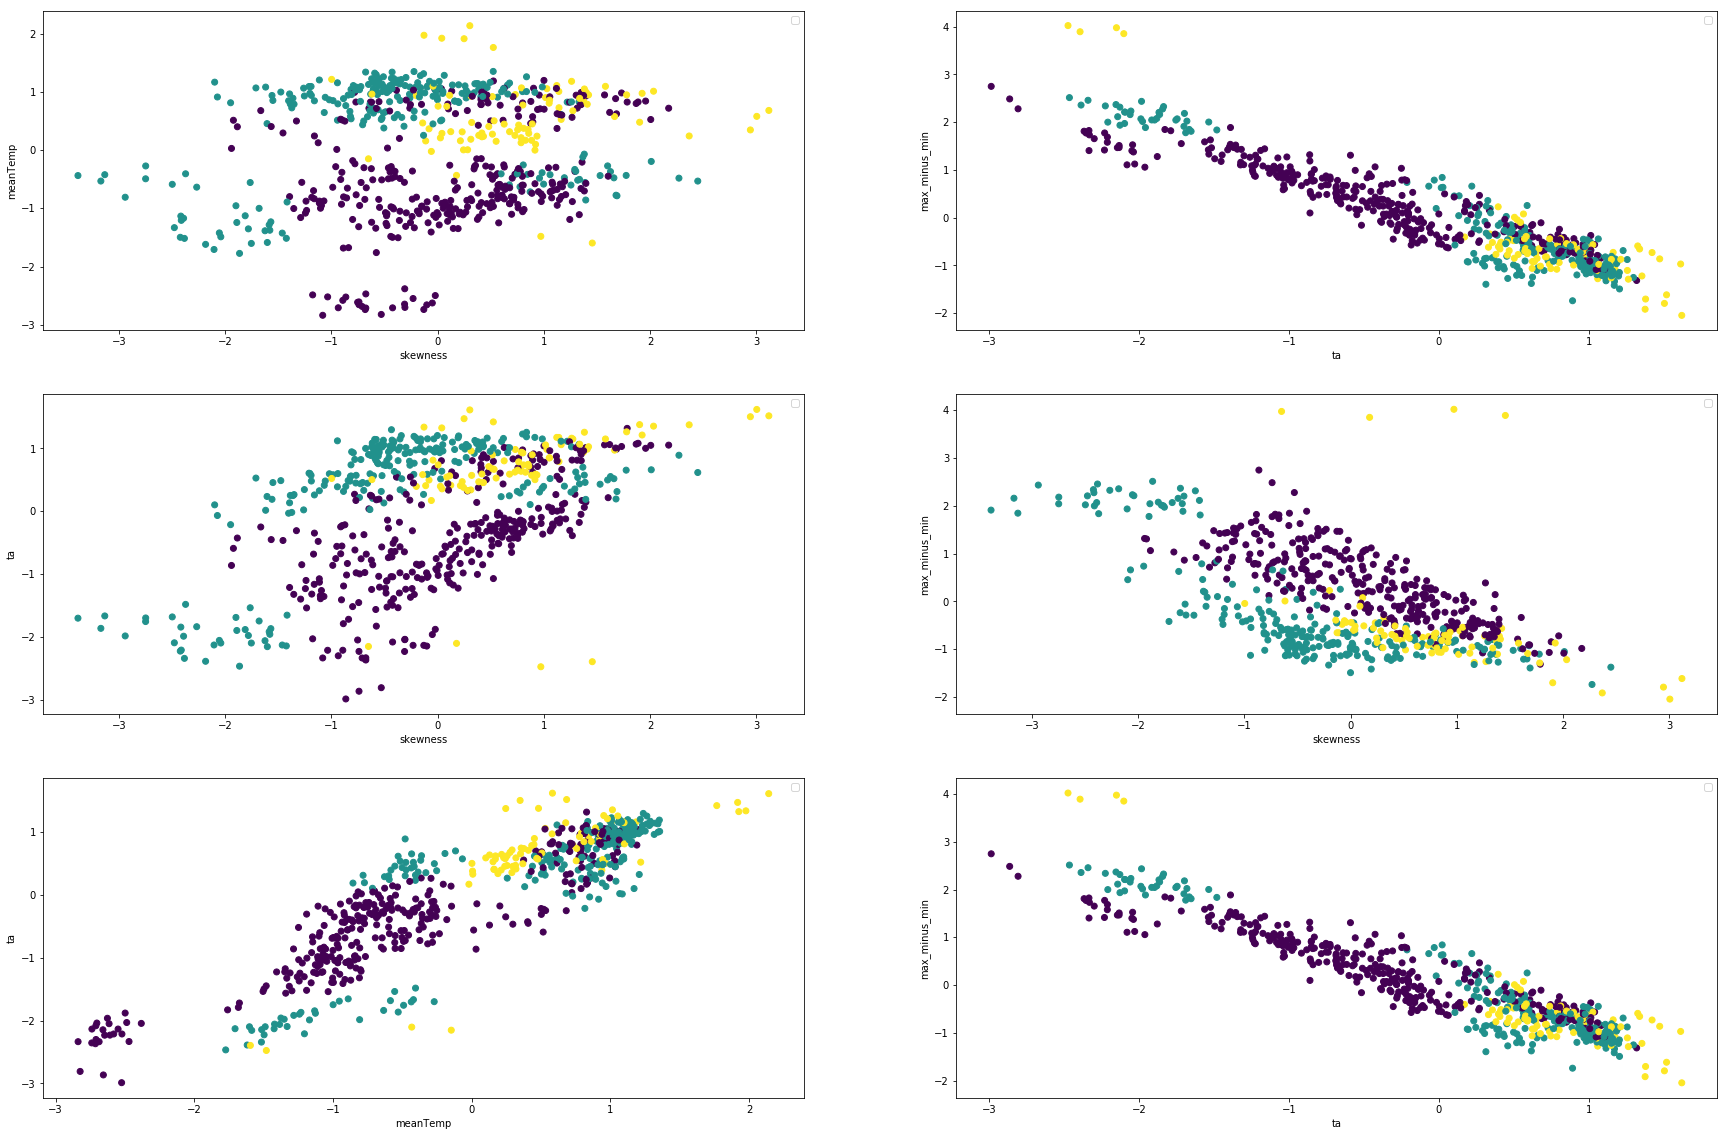

In [13]:
plt.figure(figsize=(30, 20))

plt.subplot(321)
plt.scatter(X_new[:, 0], X_new[:, 1], c=train_y)
# 注意到color参数使用train_y
plt.xlabel('skewness')
plt.ylabel('meanTemp')
plt.legend()

plt.subplot(322)
plt.scatter(X_new[:, 2], X_new[:, 3], c=train_y)
plt.xlabel('ta')
plt.ylabel('max_minus_min')
plt.legend()

plt.subplot(323)
plt.scatter(X_new[:, 0], X_new[:, 2], c=train_y)
plt.xlabel('skewness')
plt.ylabel('ta')
plt.legend()

plt.subplot(324)
plt.scatter(X_new[:, 0], X_new[:, 3], c=train_y)
plt.xlabel('skewness')
plt.ylabel('max_minus_min')
plt.legend()

plt.subplot(325)
plt.scatter(X_new[:, 1], X_new[:, 2], c=train_y)
plt.xlabel('meanTemp')
plt.ylabel('ta')
plt.legend()

plt.subplot(326)
plt.scatter(X_new[:, 2], X_new[:, 3], c=train_y)
plt.xlabel('ta')
plt.ylabel('max_minus_min')
plt.legend()

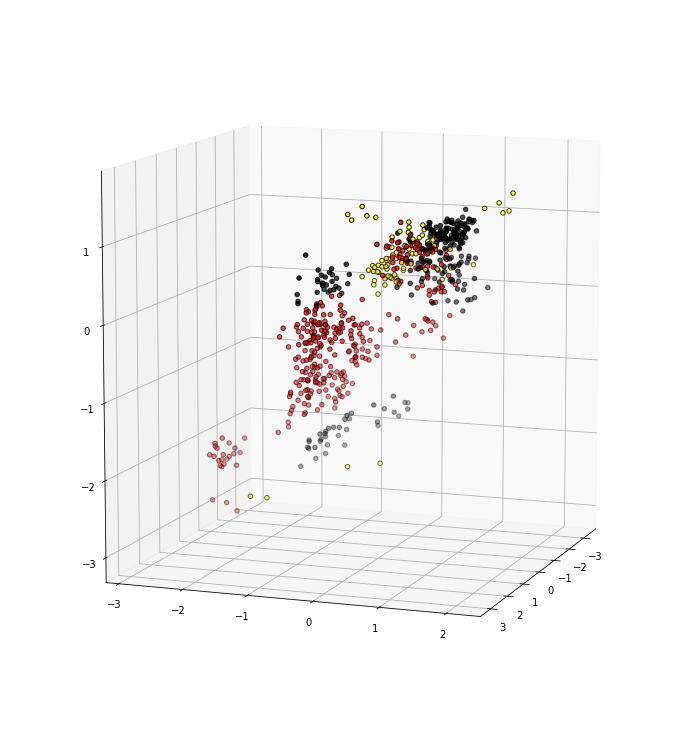

In [44]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=10, azim=20)

LABEL_COLOR_MAP = {1 : 'red',
                   2 : 'black',
                   3 : 'yellow'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in train_y]

ax.scatter(X_new[:, 0], X_new[:, 1], X_new[:, 2],
           c=label_color, edgecolor='k')